In [31]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing
data_path = 'simulated_transaction_2024.csv'
df = pd.read_csv(data_path)

# Remove duplicate entries
df = df.drop_duplicates()


# Convert data types - treating account numbers as strings to preserve leading zeros if any
df['Account No'] = df['Account No'].astype(str)
df['Third Party Account No'] = df['Third Party Account No'].astype(str)

# Handle missing values in 'Third Party Name'
# If 'Third Party Name' is NaN and 'Third Party Account No' is numeric, mark as "Transfer"
df.loc[df['Third Party Name'].isnull() & df['Third Party Account No'].str.isnumeric(), 'Third Party Name'] = 'Transfer'

# Display the first few rows of the preprocessed data
print(df.head())


         Date Timestamp   Account No  Balance  Amount Third Party Account No  \
0  01/01/2023     00:00  678330503.0   2971.0  1584.0                    nan   
1  01/01/2023     00:00  472213568.0   3792.0  1950.0                    nan   
2  01/01/2023     00:00  472213568.0   3012.0  -780.0            283027736.0   
3  01/01/2023     00:00  283027736.0   1787.0   780.0            472213568.0   
4  01/01/2023     00:00  624500124.0   3226.0  1825.0                    nan   

     Third Party Name  
0  Westport Care Home  
1    Barbiee Boutique  
2                 NaN  
3                 NaN  
4            Fat Face  


In [2]:
# Ensure 'Date' column is of datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month
df['YearMonth'] = df['Date'].dt.to_period('M')

# Calculate total outflow for each account for each month (assuming outflow is negative in the Amount column)
monthly_outflow = df[df['Amount'] < 0].groupby(['Account No', 'YearMonth'])['Amount'].sum().reset_index()
monthly_outflow.columns = ['Account No', 'YearMonth', 'Monthly_Outflow']

# Convert outflow to positive values since outflows are typically recorded as negative
monthly_outflow['Monthly_Outflow'] = monthly_outflow['Monthly_Outflow'].abs()

# First calculate total number of months for each account for averaging
months_per_account = monthly_outflow.groupby('Account No').size()

# Calculate total outflow for each account (now in positive values)
total_outflow_per_account = monthly_outflow.groupby('Account No')['Monthly_Outflow'].sum()

# Calculate average monthly consumption (positive values)
monthly_avg_consumption = (total_outflow_per_account / months_per_account).reset_index()
monthly_avg_consumption.columns = ['Account No', 'Average Monthly Consumption']

# Display the average monthly consumption for each account along with corresponding levels
print(monthly_avg_consumption)


      Account No  Average Monthly Consumption
0    101531259.0                  1468.965000
1    104832000.0                  2092.960000
2    105375973.0                   841.147500
3    106601471.0                   648.000000
4    108481285.0                  1255.423333
..           ...                          ...
972  996042490.0                  2939.000833
973  998390769.0                  1938.486364
974  998405607.0                   734.680000
975  999752672.0                  2549.189167
976          nan                  1286.454167

[977 rows x 2 columns]


C:\Users\郭程鹏\AppData\Local\Temp\ipykernel_28924\1215489247.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

k = 3

# Run KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(monthly_avg_consumption[['Average Monthly Consumption']])
monthly_avg_consumption['Cluster'] = kmeans.labels_

# Get the centroid values for each cluster
cluster_centers = kmeans.cluster_centers_.squeeze()

# Sort the cluster centers and get the indices after sorting
sorted_idx = np.argsort(cluster_centers)

# Create a mapping to map the sorted cluster indices to classes
cluster_to_class = {sorted_idx[0]: 'Low', sorted_idx[1]: 'Medium', sorted_idx[2]: 'High'}

# Convert the clustering results to classes
monthly_avg_consumption['Consumption Class'] = monthly_avg_consumption['Cluster'].map(cluster_to_class)

# Drop the no longer needed Cluster column
monthly_avg_consumption.drop('Cluster', axis=1, inplace=True)

# Display the updated DataFrame
print(monthly_avg_consumption)


C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


      Account No  Average Monthly Consumption Consumption Class
0    101531259.0                  1468.965000            Medium
1    104832000.0                  2092.960000            Medium
2    105375973.0                   841.147500               Low
3    106601471.0                   648.000000               Low
4    108481285.0                  1255.423333            Medium
..           ...                          ...               ...
972  996042490.0                  2939.000833              High
973  998390769.0                  1938.486364            Medium
974  998405607.0                   734.680000               Low
975  999752672.0                  2549.189167              High
976          nan                  1286.454167            Medium

[977 rows x 3 columns]


In [46]:
# First, calculate the number of large transfers for each account
large_transfers = df[df['Amount'] < - 1500].groupby('Account No')['Amount'].size().reset_index(name='Large Transfer Count')

# Next, mark which accounts have made repeated large transfers to the same account
df['RepeatedLargeTransfer'] = df[df['Amount'] < - 1500].groupby(['Account No', 'Third Party Account No']).cumcount() + 1
df_repeated = df[df['RepeatedLargeTransfer'] > 1]
accounts_with_repeated_transfers = df_repeated['Account No'].unique()

# Create a new DataFrame for security level
security_df = pd.DataFrame(df['Account No'].unique(), columns=['Account No'])

# Mark the number of large transfers
security_df = security_df.merge(large_transfers, on='Account No', how='left')

# Mark if there are repeated large transfers to the same account
security_df['Has Repeated Large Transfers'] = security_df['Account No'].isin(accounts_with_repeated_transfers)

# Merge consumption class
security_df = security_df.merge(monthly_avg_consumption[['Account No', 'Consumption Class']], on='Account No', how='left')

# Define security level classification rules
conditions = [
    security_df['Has Repeated Large Transfers'],
    security_df['Large Transfer Count'] > 0,
    security_df['Large Transfer Count'].isna() | (security_df['Large Transfer Count'] == 0)
]
choices = ['Low', 'Medium', 'High']
security_df['Security Level'] = pd.np.select(conditions, choices)

# Integrate security level and consumption class to determine the final risk level
def determine_risk_level(row):
    if row['Security Level'] == 'Low':
        return 'High Risk'
    elif row['Security Level'] == 'Medium':
        return 'Medium Risk'
    else:
        # If security level is high, further determine based on consumption class
        return 'Low Risk' if row['Consumption Class'] in ['Low'] else 'Medium Risk'

# Apply the comprehensive risk level assessment function
security_df['Risk Level'] = security_df.apply(determine_risk_level, axis=1)

# Display the final risk level DataFrame
security_df.head()


C:\Users\郭程鹏\AppData\Local\Temp\ipykernel_28924\3991354445.py:28: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  security_df['Security Level'] = pd.np.select(conditions, choices)


,Account No,Large Transfer Count,Has Repeated Large Transfers,Consumption Class,Security Level,Risk Level
0,678330503.0,NaN,False,Medium,High,Medium Risk
1,472213568.0,NaN,False,Medium,High,Medium Risk
2,283027736.0,NaN,False,Low,High,Low Risk
3,624500124.0,NaN,False,Medium,High,Medium Risk
4,203466392.0,NaN,False,High,High,Medium Risk


In [48]:
risk_levels = security_df['Risk Level'].value_counts()
(security_df.head(), risk_levels)

(    Account No  Large Transfer Count  Has Repeated Large Transfers  \
 0  678330503.0                   NaN                         False   
 1  472213568.0                   NaN                         False   
 2  283027736.0                   NaN                         False   
 3  624500124.0                   NaN                         False   
 4  203466392.0                   NaN                         False   
 
   Consumption Class Security Level   Risk Level  
 0            Medium           High  Medium Risk  
 1            Medium           High  Medium Risk  
 2               Low           High     Low Risk  
 3            Medium           High  Medium Risk  
 4              High           High  Medium Risk  ,
 Medium Risk    585
 Low Risk       326
 High Risk       66
 Name: Risk Level, dtype: int64)

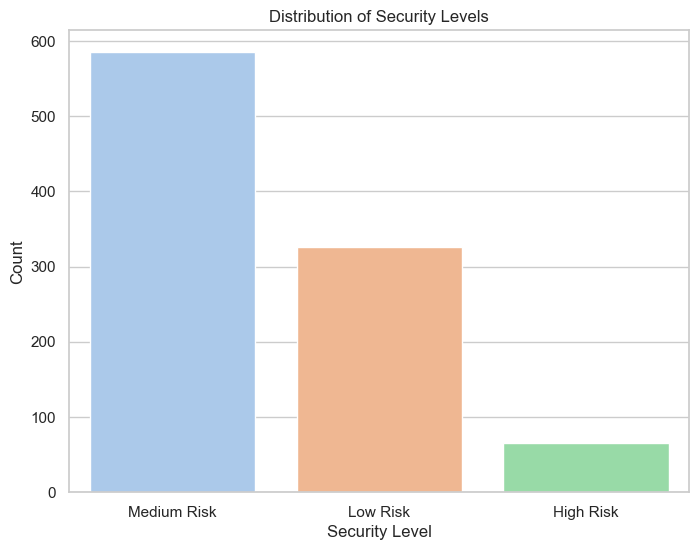

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Plot the distribution of security levels with a different color palette
plt.figure(figsize=(8, 6))
sns.countplot(x='Risk Level', data=security_df, palette='pastel')
plt.title('Distribution of Security Levels')
plt.xlabel('Security Level')
plt.ylabel('Count')
plt.show()


In [60]:
security_df.to_csv('security_measures.csv', index=False)

In [40]:
df_cleaned = df[df['Third Party Account No'].str.isnumeric()]


In [49]:
# Define the large transfer threshold
large_transfer_threshold = -1500

# Filter out all large transfer records
large_transfers = df[df['Amount'] < large_transfer_threshold]

# Calculate the number of large transfers received by each "Third Party Account No"
third_party_large_transfers = large_transfers.groupby('Third Party Account No').size()

# Filter out "Third Party Account No" that received multiple large transfers
dangerous_accounts = third_party_large_transfers[third_party_large_transfers > 1].index.tolist()

# Mark dangerous accounts
df['Dangerous Account'] = df['Third Party Account No'].isin(dangerous_accounts)

# Output the list of dangerous accounts and DataFrame with the marking
dangerous_accounts_list = df[df['Dangerous Account']]['Third Party Account No'].unique()

dangerous_accounts_list


array(['172084472.0', '548907062.0', '979135922.0', '280098744.0',
       '585596026.0', '514362267.0', '925659248.0', '250895529.0',
       '647936800.0', '950234174.0', '741269136.0', '939972497.0',
       '715068825.0', '223207876.0', '701070224.0', '242218612.0',
       '943329213.0', '986516668.0', '596463612.0', '949500755.0',
       '414454079.0', '500051919.0', '409370545.0', '986774156.0',
       '122884111.0', '462962606.0', '150489918.0', '138609932.0',
       '962295212.0', '423208402.0', '673025413.0', '228136274.0',
       '492058070.0', '985188462.0', '637649383.0', '385685918.0',
       '151278285.0', '421881811.0', '535804582.0', '575652395.0',
       '987656636.0', '235310449.0', '815993333.0', '971129830.0',
       '165045150.0', '475277431.0', '185246571.0', '229448150.0',
       '497809732.0', '173335108.0', '531186970.0', '121363710.0',
       '711045550.0', '769319491.0', '713057426.0', '280200287.0',
       '224112146.0', '517934629.0', '348525881.0', '214765415

In [105]:
import pandas as pd
import numpy as np

# Load data
data_path = 'simulated_transaction_2024.csv'
df = pd.read_csv(data_path)

# Merge Date and Timestamp columns into a single DateTime column and convert to datetime type
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Timestamp'])
df.drop(['Date', 'Timestamp'], axis=1, inplace=True)  # Remove original Date and Timestamp columns

# Convert Account No and Third Party Account No to string and handle missing values
df['Account No'] = df['Account No'].astype(str).str.replace('.0', '', regex=False)
df['Third Party Account No'] = df['Third Party Account No'].astype(str).str.replace('.0', '', regex=False)
df['Third Party Account No'] = df['Third Party Account No'].replace('nan', np.nan)  # Convert 'nan' string to NaN

# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove integers
df = df[~df['Amount'].astype(str).str.isnumeric()]

# Remove transactions involving third party accounts (non-null Third Party Account No)
df = df[df['Third Party Account No'].isnull()]

# Convert negative amounts to positive
df['Amount'] = df['Amount'].abs()

# Identify outflows (negative amounts)
df['Outflow'] = df['Amount'].apply(lambda x: -x if x < 0 else 0)



# Calculate volatility (standard deviation of monthly outflows)
df['YearMonth'] = df['DateTime'].dt.to_period('M')
volatility = df.groupby('Account No')['Outflow'].std().reset_index(name='Volatility')

# Calculate outlier rate (transactions beyond 3 standard deviations)
df['Outlier'] = abs(df['Amount'] - df['Amount'].mean()) > df['Amount'].std() * 3
outlier_rate = df.groupby('Account No')['Outlier'].mean().reset_index(name='Outlier Rate')

# Calculate concentration (Gini coefficient-like calculation for transaction frequency to third parties)
concentration = df.groupby(['Account No', 'Third Party Account No']).size()
concentration = concentration.groupby(level=0).apply(lambda x: (x**2).sum() / x.sum()**2).reset_index(name='Concentration')

# Calculate average growth rate (percentage change in amount month-to-month)
growth_rate = df.groupby('Account No')['Amount'].pct_change().groupby(df['Account No']).mean().reset_index(name='Average Growth Rate')

# Merge all metrics into a single DataFrame
security_measures = pd.DataFrame(df['Account No'].unique(), columns=['Account No'])
security_measures = security_measures.merge(volatility, on='Account No', how='left')
security_measures = security_measures.merge(outlier_rate, on='Account No', how='left')
security_measures = security_measures.merge(concentration, on='Account No', how='left')
security_measures = security_measures.merge(growth_rate, on='Account No', how='left')

# Define risk level assessment based on the computed metrics
def risk_level(row):
    if (row['Volatility'] > security_measures['Volatility'].quantile(0.75) or
        row['Outlier Rate'] > 0.05 or
        row['Concentration'] > 0.5 or
        row['Average Growth Rate'] < 0):
        return 'High Risk'
    elif (row['Volatility'] > security_measures['Volatility'].quantile(0.5) or
          row['Outlier Rate'] > 0.03 or
          row['Concentration'] > 0.3):
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Apply the risk level assessment function
security_measures['Risk Level'] = security_measures.apply(risk_level, axis=1)

# Display the final risk levels
print(security_measures[['Account No', 'Risk Level']])


C:\Users\郭程鹏\AppData\Local\Temp\ipykernel_28924\727956462.py:44: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  concentration = concentration.groupby(level=0).apply(lambda x: (x**2).sum() / x.sum()**2).reset_index(name='Concentration')


    Account No   Risk Level
0    678330503     Low Risk
1    472213568    High Risk
2    624500124  Medium Risk
3    203466392     Low Risk
4    768271776    High Risk
..         ...          ...
972  299652176     Low Risk
973  300095518     Low Risk
974  198630866     Low Risk
975  666952234     Low Risk
976  170233640     Low Risk

[977 rows x 2 columns]


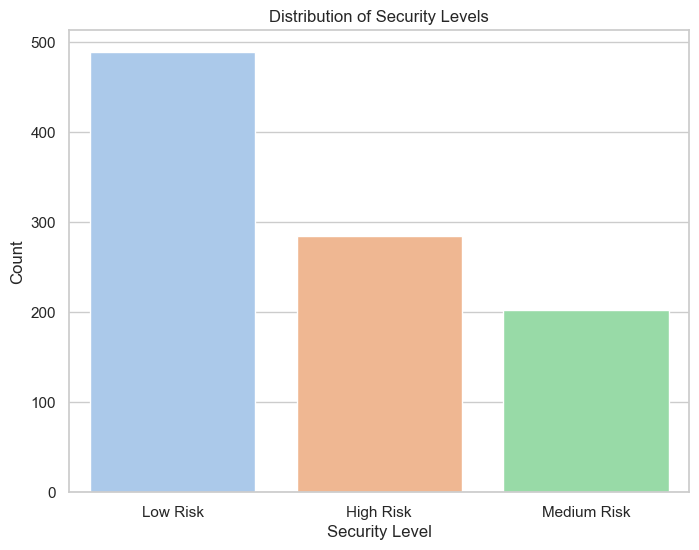

In [106]:
# Set the style
sns.set(style="whitegrid")

# Plot the distribution of security levels with a different color palette
plt.figure(figsize=(8, 6))
sns.countplot(x='Risk Level', data=security_measures, palette='pastel')
plt.title('Distribution of Security Levels')
plt.xlabel('Security Level')
plt.ylabel('Count')
plt.show()

In [107]:
# Filter accounts with "High Risk" level
high_risk_accounts_measures = security_measures[security_measures['Risk Level'] == 'High Risk']
high_risk_accounts_df = security_df[security_df['Risk Level'] == 'High Risk']

# Merge the two DataFrames on 'Account No'
high_risk_accounts = pd.merge(high_risk_accounts_measures, high_risk_accounts_df, on='Account No', how='inner')

# Display the new table
print(high_risk_accounts)


Empty DataFrame
Columns: [Account No, Volatility, Outlier Rate, Concentration, Average Growth Rate, Risk Level_x, Large Transfer Count, Has Repeated Large Transfers, Consumption Class, Security Level, Risk Level_y]
Index: []


In [108]:
high_risk_accounts

,Account No,Volatility,Outlier Rate,Concentration,Average Growth Rate,Risk Level_x,Large Transfer Count,Has Repeated Large Transfers,Consumption Class,Security Level,Risk Level_y


In [109]:
high_risk_accounts_measures

,Account No,Volatility,Outlier Rate,Concentration,Average Growth Rate,Risk Level
1,472213568,0.0,0.060302,NaN,4.809570,High Risk
4,768271776,0.0,0.063492,NaN,2.620284,High Risk
6,350921975,0.0,0.068966,NaN,11.249788,High Risk
7,455831435,0.0,0.069364,NaN,2.829585,High Risk
10,172084472,0.0,0.110092,NaN,7.750273,High Risk
...,...,...,...,...,...,...
819,405945930,0.0,0.058511,NaN,4.218319,High Risk
830,583579399,0.0,0.051887,NaN,2.654081,High Risk
837,901037631,0.0,0.052133,NaN,3.498110,High Risk
898,779376323,0.0,0.053922,NaN,3.458209,High Risk


In [111]:
high_risk_accounts_df

,Account No,Large Transfer Count,Has Repeated Large Transfers,Consumption Class,Security Level,Risk Level
12,407574996.0,3.0,True,High,Low,High Risk
17,865748375.0,2.0,True,High,Low,High Risk
21,616924659.0,12.0,True,High,Low,High Risk
49,308068836.0,2.0,True,High,Low,High Risk
64,454356905.0,4.0,True,Medium,Low,High Risk
...,...,...,...,...,...,...
756,611143859.0,6.0,True,High,Low,High Risk
771,492215823.0,4.0,True,High,Low,High Risk
773,914806976.0,2.0,True,Medium,Low,High Risk
781,651756497.0,7.0,True,High,Low,High Risk
